# Timeseries prediction using LSTM

## Introduction

## Setup

In [ ]:
!pip install matplotlib
!pip install seaborn
!pip install bs4

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
!pip install finance-datareader

     |████████████████████████████████| 75 kB 6.3 MB/s  eta 0:00:01


## Load the dataset

In [3]:
import FinanceDataReader as fdr

stock = fdr.DataReader('AMZN', '2017')

In [4]:
stock.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
               '2017-01-13', '2017-01-17',
               ...
               '2021-05-10', '2021-05-11', '2021-05-12', '2021-05-13',
               '2021-05-14', '2021-05-17', '2021-05-18', '2021-05-19',
               '2021-05-20', '2021-05-21'],
              dtype='datetime64[ns]', name='Date', length=1104, freq=None)

In [5]:
stock['Year'] = stock.index.year
stock['Month'] = stock.index.month
stock['Day'] = stock.index.day

stock.head()

,Close,Open,High,Low,Volume,Change,Year,Month,Day
Date,,,,,,,,,
2017-01-03,753.67,757.92,758.76,747.70,3520000.0,0.0051,2017,1,3
2017-01-04,757.18,758.39,759.68,754.20,2510000.0,0.0047,2017,1,4
2017-01-05,780.45,761.55,782.40,760.26,5830000.0,0.0307,2017,1,5
2017-01-06,795.99,782.36,799.44,778.48,5990000.0,0.0199,2017,1,6
2017-01-09,796.92,798.00,801.77,791.77,3450000.0,0.0012,2017,1,9


## Visualize the data

Text(0, 0.5, 'price')

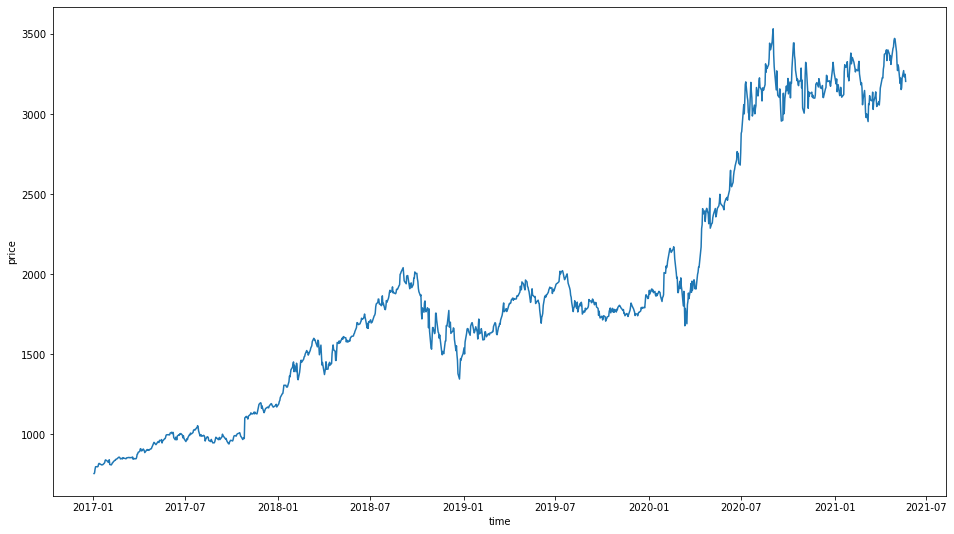

In [6]:
plt.figure(figsize=(16, 9))
sns.lineplot(y=stock['Close'], x=stock.index)
plt.xlabel('time')
plt.ylabel('price')

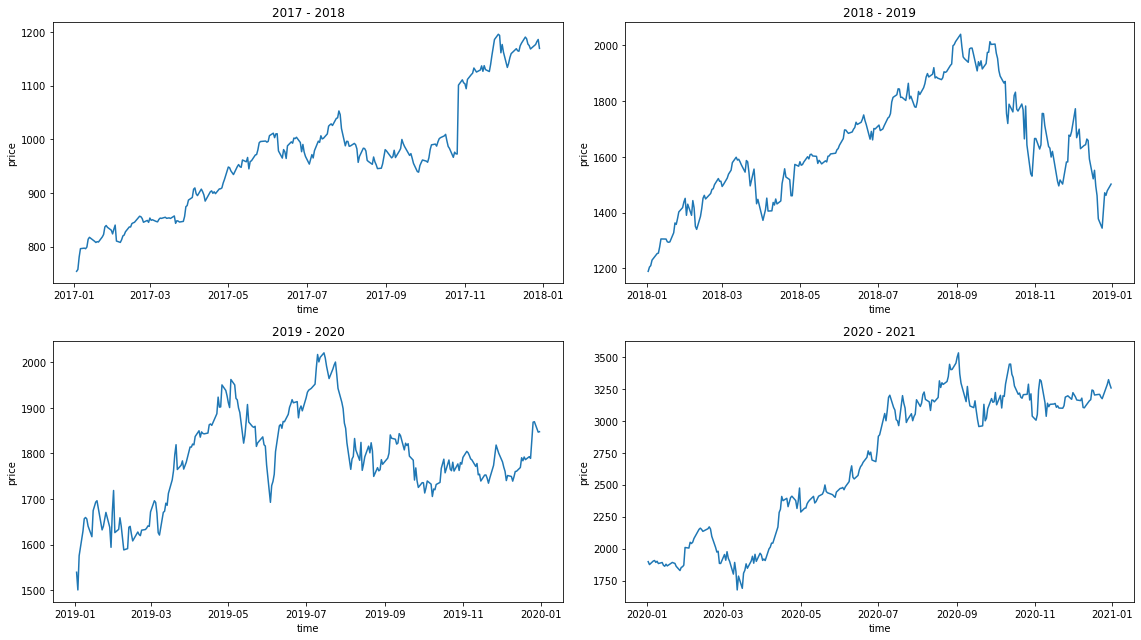

In [7]:
time_steps = [['2017', '2018'], 
              ['2018', '2019'], 
              ['2019', '2020'], 
              ['2020', '2021']]

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 9)

for i in range(4):
    ax = axes[i//2, i%2]
    df = stock.loc[(stock.index > time_steps[i][0]) & (stock.index < time_steps[i][1])]
    sns.lineplot(y = df['Close'], x = df.index, ax = ax)
    ax.set_title(f'{time_steps[i][0]} - {time_steps[i][1]}')
    ax.set_xlabel('time')
    ax.set_ylabel('price')
    
plt.tight_layout()
plt.show()

## Preapare training data

In [8]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
scaled = scaler.fit_transform(stock[scale_cols])
df = pd.DataFrame(scaled, columns=scale_cols)
df.head()

,Open,High,Low,Close,Volume
0,0.000000,0.000000,0.000000,0.000000,0.168189
1,0.000169,0.000329,0.002373,0.001264,0.103811
2,0.001302,0.008457,0.004586,0.009641,0.315429
3,0.008763,0.014553,0.011238,0.015235,0.325628
4,0.014370,0.015387,0.016090,0.015570,0.163727


In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.3, random_state=0, shuffle=False)
x_train.shape, x_test.shape

((772, 4), (332, 4))

In [10]:
input_size = x_train.shape[1]

x_train = np.array(x_train)
x_test = np.array(x_test)

In [11]:
x_train = x_train.reshape(x_train.shape[0], 1, input_size)
x_test = x_test.reshape(x_test.shape[0], 1, input_size)

x_train.shape, x_test.shape

((772, 1, 4), (332, 1, 4))

## Build a model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, LSTM

model = Sequential()
model.add(LSTM(512,input_shape = (1,input_size)))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'relu'))

model.compile(loss ='mse', optimizer = 'rmsprop', metrics = ['mae', 'mape'])
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 512)               1058816   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 513       
Total params: 1,059,329
Trainable params: 1,059,329
Non-trainable params: 0
_________________________________________________________________


## Train the model

In [13]:
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20, batch_size = 128)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 772 samples, validate on 332 samples
Epoch 1/20
772/772 [==============================] - 4s 5ms/sample - loss: 0.0421 - mean_absolute_error: 0.1701 - mean_absolute_percentage_error: 40899.4844 - val_loss: 0.1472 - val_mean_absolute_error: 0.3651 - val_mean_absolute_percentage_error: 46.1854
Epoch 2/20
772/772 [==============================] - 0s 352us/sample - loss: 0.0076 - mean_absolute_error: 0.0787 - mean_absolute_percentage_error: 168992.1719 - val_loss: 0.0611 - val_mean_absolute_error: 0.2293 - val_mean_absolute_percentage_error: 28.2461
Epoch 3/20
772/772 [==============================] - 0s 354us/sample - loss: 0.0051 - mean_absolute_error: 0.0614 - mean_absolute_percentage_error: 185731.7656 - val_loss: 0.0505 - val_mean_absolute_error: 0.2092 - val_mean_absolute_percentage_error: 25.8692
Epoch 4/20
772/772 [==============================] - 0s 369us/sample - loss: 0.003

In [14]:
pred = model.predict(x_test)

## Predicting values
### Plot training and validation loss

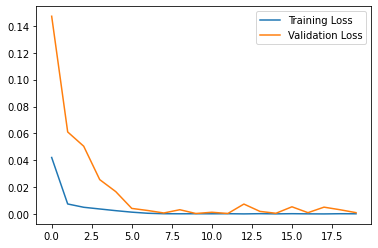

In [15]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

### Compare actual and prediction with validation data

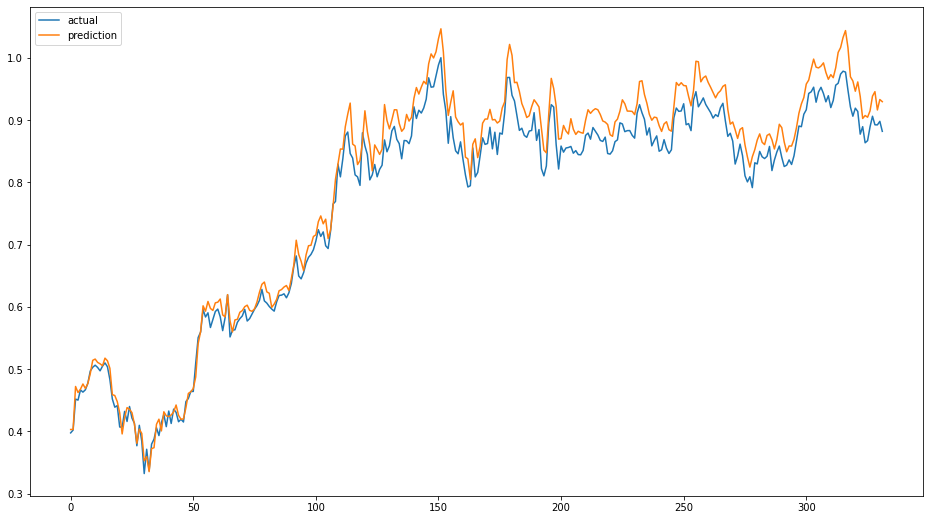

In [16]:
plt.figure(figsize=(16, 9))
plt.plot(np.asarray(y_test), label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()